## 航空宇宙情報システム学第二

<h1><center> 第6回 続・線型最小二乗法 〜過剰適合と正則化〜 </center> </h1>

<center>

2023年5月9日

担当教員: 矢入健久

e-mail: yairi@g.ecc.u-tokyo.ac.jp
</center>


# はじめに

前回は最も基本的なデータ解析手法の一つである最小二乗法による線形回帰を学びました。
今回は、統計学および機械学習における重大問題である過剰適合(あるいは過学習, 英語では overfitting) とその有効な対処法の一つである正則化(regularization)について話をします。

本来、過剰適合も正則化も、回帰に特化した話ではないのですが、前回からの流れで回帰問題と合わせて扱うことにします。

## 回帰モデルを予測に使う

関数当てはめ(curve fitting)あるいは回帰(regression)問題とは、
説明変数($\boldsymbol{x}$)と目標変数($y$)に関するデータが与えられたときに、関数$y \approx f_{\boldsymbol{\alpha}}(\boldsymbol{x})$を求めること（より正確には、パラメータ$\boldsymbol{\alpha}$の値を求めること）でした。

回帰を行うことの目的の一つは、与えられたデータを分析して何らかの洞察を得ることですが、もう一つの目的は、<font color="blue">データから推定された関数（回帰モデル）$f_{\boldsymbol{\alpha}}(\boldsymbol{x})$を用いて、与えられた入力$\boldsymbol{x}$から数値出力$y$を予測する</font>ことです。そのような数値出力の予測問題は至るところに存在しています。株価や不動産価格、商品の売上、製造品の品質や残存寿命の予測など、枚挙に暇がありません。

## 訓練データとテストデータ

前回は、各問題で与えられたデータを全て使って回帰モデルのパラメータを推定しました。例えば、単回帰の例題として最初に扱った「ココア消費量とノーベル賞受賞者数」の問題では、データに含まれる全ての国についての$x$(1人あたりのココア消費量)と$y$(単位人口あたりのノーベル賞受賞者数)の数値を使って、$f(x)=a_0 + a_1 x$のパラメータ$a_0$,$a_1$を求めました。

再度、やってみます。


[-1.51800489  4.36907945]


Text(0, 0.5, 'Nobel Laureates per 10 million')

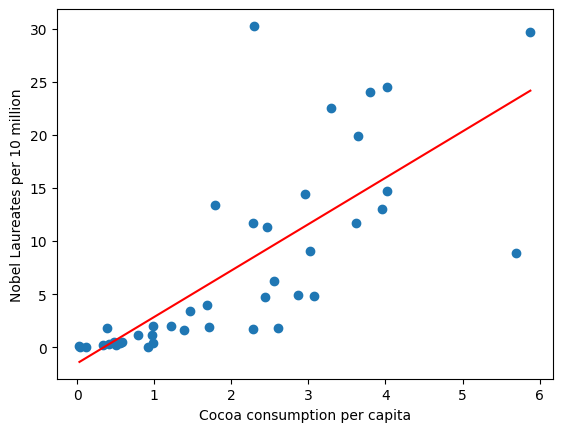

In [ ]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import pandas as pd
df1 = pd.read_csv('/content/drive/My Drive/cocoa-nobel.csv',index_col=0)
# データに含まれている全ての国の数
n = len(df1)
# ココア消費量
x = df1.iloc[:,0].values
# ノーベル受賞者数
y = df1.iloc[:,1].values
# x の左隣に全部1の列ベクトルを付け足した行列
X = np.stack((np.ones(n),x),1)
# 係数行列 np.dot(X.T,X) , 定数ベクトル np.dot(X.T,y)
alp = la.solve(np.dot(X.T,X),np.dot(X.T,y))
# res = la.lstsq(X,y)
# alp = res[0]
print(alp)
# 直線にあてはめたyの値
yhat = np.dot(X,alp)
plt.scatter(x,y)
plt.plot(x,yhat,'r-')
plt.xlabel('Cocoa consumption per capita')
plt.ylabel('Nobel Laureates per 10 million')

データ分析が目的であればこれで良いかもしれません。

しかし、得られた回帰モデル $y = -1.52 + 4.37 x$を使って、他の国について予測してみたくても、試すデータが残っていません。

そこで、<font color="blue">データを半分ずつ2つに分けて、片方を使って回帰モデルのパラメータを推定し、もう一方の$x$の値を使って$y$の値を予測する</font>（そして、真の$y$の値と比較する）ということを行ってみます。
このとき、前者のデータを**訓練データ(training data)**、後者のデータを**テストデータ(test data)**と呼びます。

今回は説明を簡単にするため、偶数番目(0,2,4,..,40)の国の値を訓練データに、奇数番目(1,3,5,..,39)の国の値をテストデータにしますが、別の分け方でも構いません。



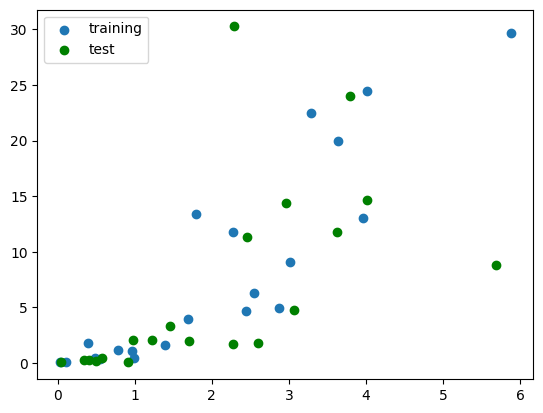

In [ ]:
#全データ X,y を、訓練データXtr,ytr, テストデータ Xte,yte に分ける
# 訓練データ
Xtr,ytr = X[0::2,:],y[0::2]
# テストデータ
Xte,yte = X[1::2,:],y[1::2]

# 色を変えてプロットしてみる
plt.scatter(Xtr[:,1],ytr,label="training")
plt.scatter(Xte[:,1],yte,label="test",color="g")
plt.legend()

次に、
1. 訓練データで回帰モデルのパラメータを推定し、訓練データについてのRMSE(二乗平均平方根誤差)を求めます。
2. 同じ回帰モデルをテストデータの$x$に適用して$y$の予測値($\hat{y})$を求めて、テストデータについてのRMSEを計算します。


a_0= -2.6646900420098625 a_1= 5.254961532163393
RMSE(training): 4.084165937706255
RMSE(test): 7.464891504248309


Text(0.5, 1.0, 'RMSE(Test):7.465')

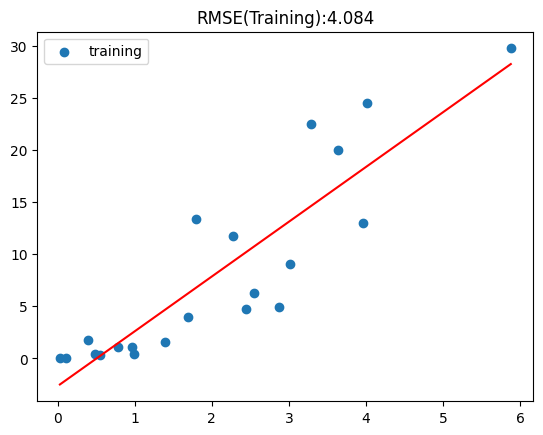

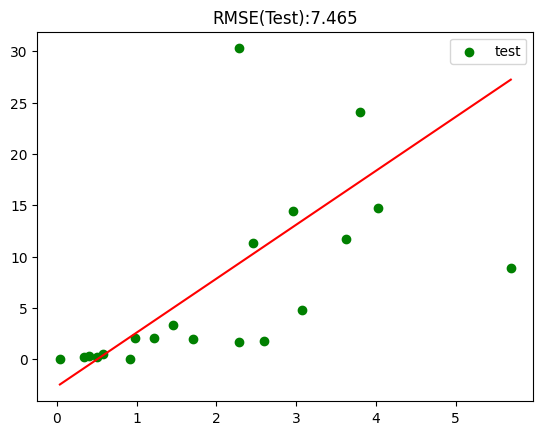

In [ ]:
# 訓練データを使って、単回帰モデルのパラメータ(切片、傾き)を推定
alp = la.solve(np.dot(Xtr.T,Xtr),np.dot(Xtr.T,ytr))
print("a_0=",alp[0], "a_1=",alp[1])
# 訓練データについて、yhatを求めて、RMSEを計算
yhtr = np.dot(Xtr,alp)
rmsetr = np.sqrt(np.mean((ytr-yhtr)**2))
print("RMSE(training):",rmsetr)
# 一応グラフも書いておく
plt.scatter(Xtr[:,1],ytr,label="training")
plt.plot(Xtr[:,1],yhtr,"r-")
plt.legend()
plt.title("RMSE(Training):{:.3f}".format(rmsetr))

# テストデータについて、yhatを求めて、RMSEを計算
yhte = np.dot(Xte,alp)
rmsete = np.sqrt(np.mean((yte-yhte)**2))
print("RMSE(test):",rmsete)
plt.figure()
plt.scatter(Xte[:,1],yte,label="test",color="g")
plt.plot(Xte[:,1],yhte,"r-")
plt.legend()
plt.title("RMSE(Test):{:.3f}".format(rmsete))



ぱっと見たところ、今回の場合、テストデータの方がたまたまばらつきが大きいということもありますが、<font color="red">訓練データに対するRMSEが4.08であるのに対して、テストデータに対するRMSEは7.46</font>と、大きくなっていることが分かります。

直感的に考えても、この単回帰モデルは、訓練データに「特化」しているので、<font color="blue">訓練に使っていないテストデータに対する予測精度が低下するのは自然</font>です。しかし、予測用途に使うのであれば、できるだけ予測精度は高くしたい、言い換えれば、テストデータのRMSEを訓練データのRMSEに近づけたいということになります。


# 過剰適合

上で述べたように、回帰モデルを予測に使う場合、<font color="blue">テストデータに対するRMSEが訓練データに対するRMSEにできるだけ近い</font>ことが理想的ですが、それとは逆に、<font color="red"> テストRMSEが訓練RMSEよりも著しく大きくなってしまうことを過剰適合(overfitting) </font>と呼びます。
過剰適合は、その名前の通り、モデルが訓練データに過剰に適合してしまい、汎化能力が失われてしまう現象を意味します。

## 多項式回帰の例

「ココア・ノーベル賞」データセットを使って、過剰適合が具体的にどういうものかを見てみましょう。

まず、現在の単回帰モデル(=1次の多項式回帰モデル)を1つだけ次数を上げて、2次の多項式回帰モデル
$$
y=a_0 + a_1 x + a_2 x^2
$$
でやってみましょう。このモデルも<font color="blue">**パラメータに対して線形なので、線形回帰モデル** </font>であることに注意してください。そして、<font color="blue">訓練データの</font>説明変数のデータ行列$\boldsymbol{X}$を、
$$
\boldsymbol{X} =  
\left[\begin{matrix}
1 & x_0 & x_0^2\\
1 & x_1 &  x_1^2\\
\vdots \\
1 & x_{n-1} & x_{n-1}^2\\
\end{matrix}\right]
$$
のように作れば、最小二乗法による解は、正規方程式
$$
\boldsymbol{X}^\top \boldsymbol{X} \boldsymbol{\alpha}=\boldsymbol{X}^\top\boldsymbol{y} \\
$$
を、$\boldsymbol{\alpha}$について解いたもの、すなわち、
$$
\hat{\boldsymbol{\alpha}} = \left( \boldsymbol{X}^\top \boldsymbol{X} \right)^{-1}\boldsymbol{X}^\top\boldsymbol{y}
$$
として得られます。

そして、<font color="blue">訓練データについての目標変数の予測(再現)値</font>は、
$$
\hat{\boldsymbol{y}} = \boldsymbol{X} \hat{\boldsymbol{\alpha}}
$$
で求まります。

一方、<font color="green">テストデータの</font>説明変数のデータ行列を、$\boldsymbol{X}^\prime$とすれば、
<font color="green">テストデータの目標変数の予測値</font>は、
$$
\hat{\boldsymbol{y}}^\prime = \boldsymbol{X}^\prime \hat{\boldsymbol{\alpha}}
$$
として求まります。

**(注意)** 訓練データ、テストデータを明確に区別するためには、本当は、
$\boldsymbol{X}_{\mbox{train}}$,$\boldsymbol{y}_{\mbox{train}}$,$\boldsymbol{X}_{\mbox{test}}$,$\boldsymbol{y}_{\mbox{test}}$ のような表記をした方が良いのですが、見た目が煩雑になり過ぎるので、ここでは簡略化しています。


In [ ]:
# 2次の多項式回帰モデル y = a0 + a1 x + a2 x^2
ntr,nte = len(ytr),len(yte)
# 入力(説明)変数のデータ行列を生成
Xtr,Xte = np.ones((ntr,1)),np.ones((nte,1))
for k in range(1,3):
  Xtr = np.hstack((Xtr,(X[0::2,1]**k).reshape(-1,1)))
  Xte = np.hstack((Xte,(X[1::2,1]**k).reshape(-1,1)))
# 訓練データで回帰モデルを作成
alp = la.solve(np.dot(Xtr.T,Xtr),np.dot(Xtr.T,ytr))
print(alp)
# 訓練データについて、yhatを求めて、RMSEを計算
yhtr = np.dot(Xtr,alp)
rmsetr = np.sqrt(np.mean((ytr-yhtr)**2))
print("RMSE(training):",rmsetr)
# テストデータについてもyhatを求めて、RMSEを計算
yhte = np.dot(Xte,alp)
rmsete = np.sqrt(np.mean((yte-yhte)**2))
print("RMSE(test):",rmsete)


[-1.20624823  3.35085946  0.37661007]
RMSE(training): 3.9546149103284414
RMSE(test): 7.7889968988195175


Text(0.5, 1.0, 'RMSE(Test):7.789')

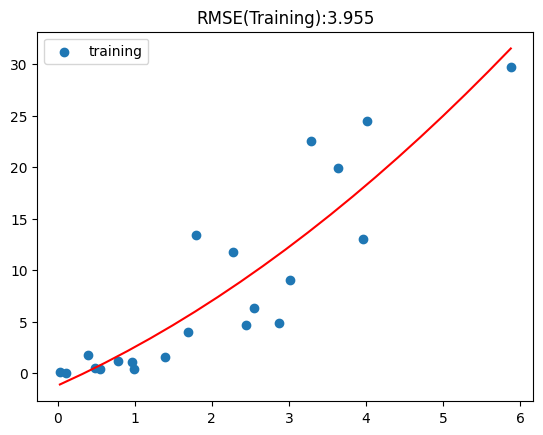

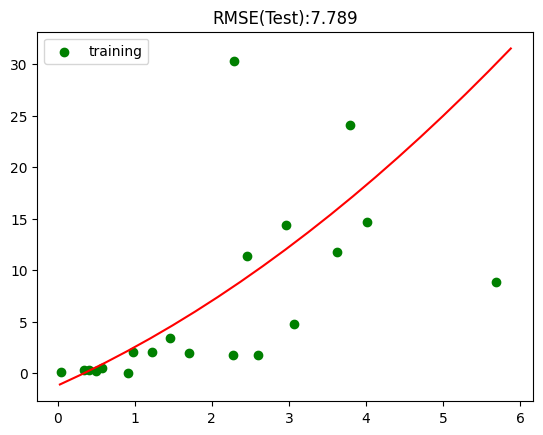

In [ ]:
# 多項式グラフのプロット用
ndum = 21
xdum = np.linspace(min(x),max(x),ndum)
Xdum = np.ones((ndum,1))
for k in range(1,3):
  Xdum = np.hstack((Xdum,(xdum**k).reshape(-1,1)))
ydum = np.dot(Xdum,alp)
# 訓練データと2次多項式回帰モデル
plt.scatter(Xtr[:,1],ytr,label="training")
plt.plot(xdum,ydum,"r-")
plt.legend()
plt.title("RMSE(Training):{:.3f}".format(rmsetr))
# テストデータとモデル
plt.figure()
plt.scatter(Xte[:,1],yte,label="training",color="g")
plt.plot(xdum,ydum,"r-")
plt.legend()
plt.title("RMSE(Test):{:.3f}".format(rmsete))


ここで、重要なのは、<font color="red">1次モデル(単回帰モデル)からより複雑な2次モデルに変更した結果</font>、

* <font color="blue">訓練データに対するRMSEは減少</font> ($4.08 \rightarrow 3.96$)
* <font color="red">テストデータに対するRMSEは増大</font> ($7.47 \rightarrow 7.79$)

したということです。つまり、僅かながらではありますが、訓練データに過剰適合してテストデータに対する予測性能が低下してしまっています。

さらに高次の多項式モデルで回帰してみたらどうでしょうか？ 8次までやってみます。コードがゴチャゴチャして分かりにくくてすみません。。


Order:  1
[-2.66469004  5.25496153]
RMSE(training): 4.0841659377062545
RMSE(test): 7.4648915042483095
Order:  2
[-1.20624823  3.35085946  0.37661007]
RMSE(training): 3.9546149103284414
RMSE(test): 7.7889968988195175
Order:  3
[ 0.43166275 -0.78217851  2.25498735 -0.21548922]
RMSE(training): 3.8507385073447113
RMSE(test): 7.732052953547343
Order:  4
[-0.33332909  2.58525452 -0.71222613  0.64346525 -0.07637812]
RMSE(training): 3.8307770071833316
RMSE(test): 7.836968267653672
Order:  5
[ 0.48381812 -3.70255409  8.89150491 -4.56003175  1.06309781 -0.08539304]
RMSE(training): 3.8060182188068614
RMSE(test): 8.151448497850788
Order:  6
[  1.56243348 -16.94292853  39.33742127 -30.7062462   11.21836497
  -1.88504354   0.11734024]
RMSE(training): 3.7624338782314903
RMSE(test): 6.878719153931651
Order:  7
[  -2.06981331   45.27851029 -154.92396977  205.50022821 -127.2219832
   39.79598552   -6.06197716    0.35488175]
RMSE(training): 3.3714013875034423
RMSE(test): 25.067673853123747


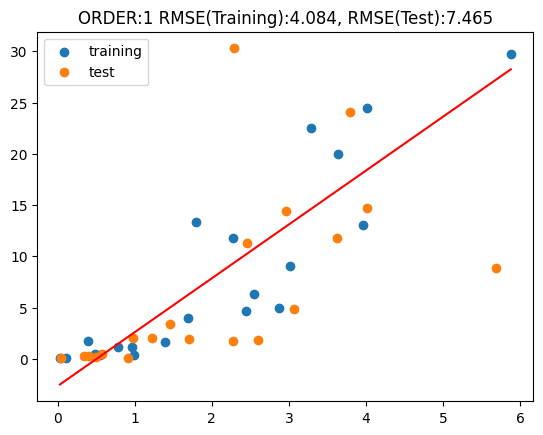

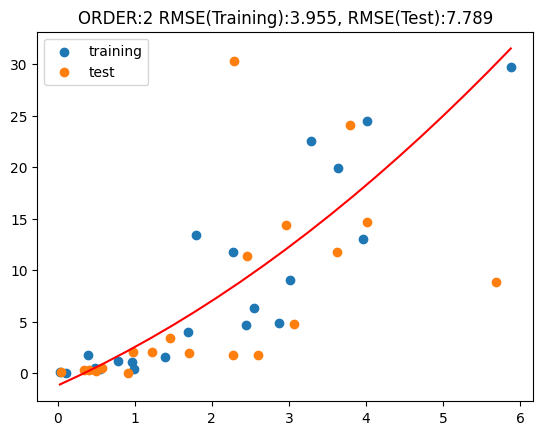

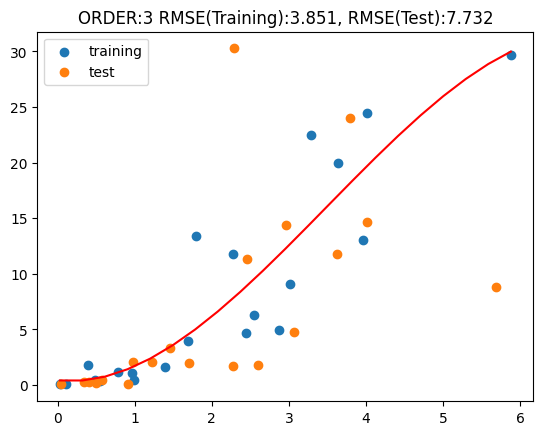

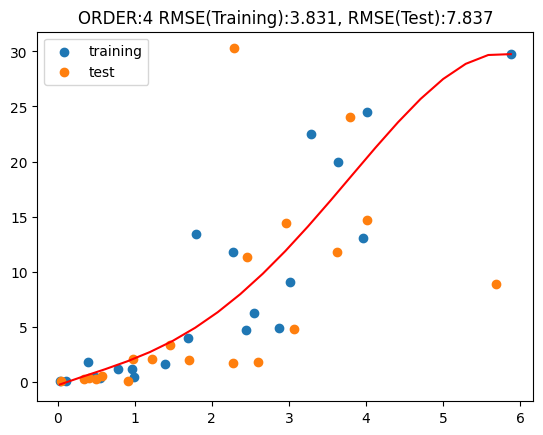

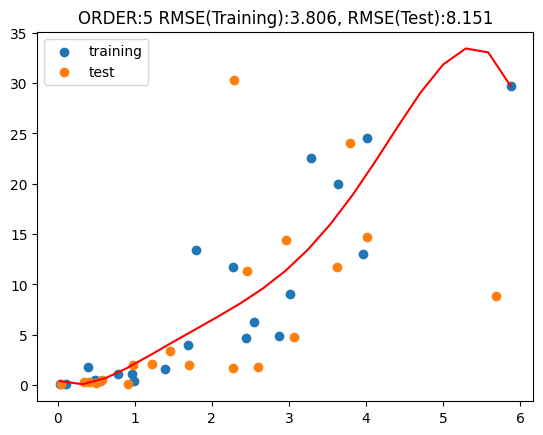

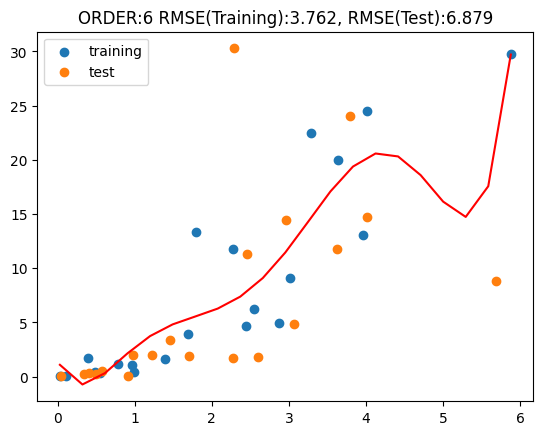

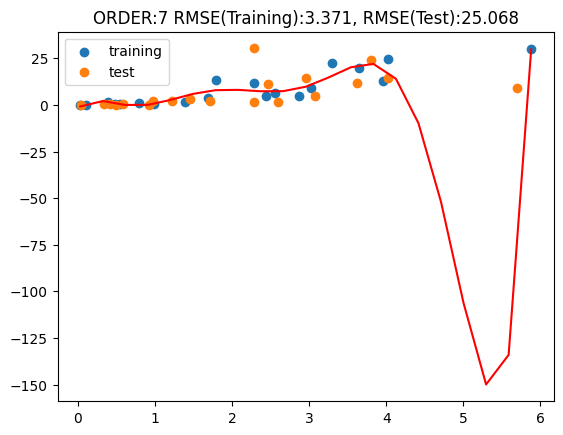

In [ ]:
## 1-8次の多項式回帰

# 各次元のRMSEの値のリスト
lst_rmsetr,lst_rmsete = [],[]

for ord in range(1,8):
  print("Order: ",ord)
  # 入力(説明)変数のデータ行列を生成
  Xtr,Xte = np.ones((ntr,1)),np.ones((nte,1))
  for k in range(1,ord+1):
    Xtr = np.hstack((Xtr,(X[0::2,1]**k).reshape(-1,1)))
    Xte = np.hstack((Xte,(X[1::2,1]**k).reshape(-1,1)))
  # 訓練データで回帰モデルを作成
  alp = la.solve(np.dot(Xtr.T,Xtr),np.dot(Xtr.T,ytr))
  print(alp)
  # 訓練データについて、yhatを求めて、RMSEを計算
  yhtr = np.dot(Xtr,alp)
  rmsetr = np.sqrt(np.mean((ytr-yhtr)**2))
  lst_rmsetr.append(rmsetr)
  print("RMSE(training):",rmsetr)
  # テストデータについてもyhatを求めて、RMSEを計算
  yhte = np.dot(Xte,alp)
  rmsete = np.sqrt(np.mean((yte-yhte)**2))
  lst_rmsete.append(rmsete)
  print("RMSE(test):",rmsete)
  # 多項式グラフのプロット用
  ndum = 21
  xdum = np.linspace(min(x),max(x),ndum)
  Xdum = np.ones((ndum,1))
  for k in range(1,ord+1):
    Xdum = np.hstack((Xdum,(xdum**k).reshape(-1,1)))
  ydum = np.dot(Xdum,alp)
  # 訓練・テストデータと2次多項式回帰モデル
  plt.figure()
  plt.scatter(Xtr[:,1],ytr,label="training")
  plt.scatter(Xte[:,1],yte,label="test")
  plt.plot(xdum,ydum,"r-")
  plt.legend()
  plt.title("ORDER:{:d} RMSE(Training):{:.3f}, RMSE(Test):{:.3f}".format(ord,rmsetr,rmsete))



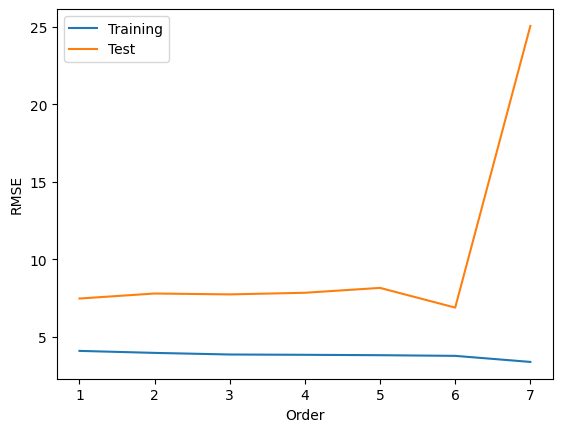

In [ ]:
# 各次元での訓練・テストRMSE
plt.plot(range(1,ord+1),lst_rmsetr,label="Training")
plt.plot(range(1,ord+1),lst_rmsete,label="Test")
plt.xlabel("Order")
plt.ylabel("RMSE")
plt.legend()

やはり、訓練データに対するRMSEは単調に減少しています。これは、モデルの自由度が増えれば増えるほど、訓練データに適合することを意味しています。
一方、テストデータに対するRMSEは、たまたま6次で一時的に減っていますが、<font color="red">7次で突然大きくなっており、グラフを見ても過剰適合が発生していることが明らか</font>です。

一般に、<font color="red">限られたサイズの訓練データで、複雑過ぎる（すなわちパラメータが多過ぎる）モデルを学習させると、過剰適合が発生</font>します。

## 重回帰での過剰適合

説明変数（機械学習的には特徴量）の数が多過ぎる場合にも、モデルが複雑になり過ぎて過剰適合が生じます。そのような例を１つ見てみたいと思います。

### (例題) ガスタービンのNOX排出量予測

前回の課題(HW2023-02)で紹介した[UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) に含まれている ["Gas Turbine CO and NOx Emission Data Set Data Set"というデータセット](https://archive.ics.uci.edu/ml/datasets/Gas+Turbine+CO+and+NOx+Emission+Data+Set)を使ってみます。このデータセットには、2011-2015年の5年間分のデータが含まれていますが、全部使うと多すぎるので、今回は2012年のデータファイル(gt_2012.csv)を使います。

このデータの詳しい説明は割愛しますが、簡単に言えば、<font color="blue">火力発電所のガスタービンから排出される有害物質である一酸化炭素(CO)と窒素酸化物(NOX)の量を、環境や燃焼の条件から予測するモデルを作る</font>のが目的らしいです。
今回は、<font color="blue">NOXの排出量を目標変数($y$)とする</font>ことにします。

とりあえず、データをPandasで読み込んでみます。

In [ ]:
dfgt = pd.read_csv('/content/drive/My Drive/gt_2012.csv')
display(dfgt)

,AT,AP,AH,AFDP,GTEP,TIT,TAT,TEY,CDP,CO,NOX
0,6.8594,1007.9,96.799,3.5000,19.663,1059.2,550.00,114.70,10.605,3.1547,82.722
1,6.7850,1008.4,97.118,3.4998,19.728,1059.3,550.00,114.72,10.598,3.2363,82.776
2,6.8977,1008.8,95.939,3.4824,19.779,1059.4,549.87,114.71,10.601,3.2012,82.468
3,7.0569,1009.2,95.249,3.4805,19.792,1059.6,549.99,114.72,10.606,3.1923,82.670
4,7.3978,1009.7,95.150,3.4976,19.765,1059.7,549.98,114.72,10.612,3.2484,82.311
...,...,...,...,...,...,...,...,...,...,...,...
7623,10.0370,1022.1,88.531,2.9192,23.641,1083.6,549.91,132.61,11.745,1.6560,76.068
7624,9.8921,1022.2,87.622,2.9415,23.859,1084.9,550.08,133.57,11.869,1.5549,74.930
7625,9.8723,1022.0,86.618,2.9309,23.817,1084.8,549.99,133.50,11.914,1.4093,75.041
7626,10.0260,1022.0,87.301,2.9363,23.831,1084.5,550.01,133.20,11.811,1.3963,74.460


本当のことを言えば、このデータは時間順に並べられているデータ、すなわち、時系列データであり、単純な線形回帰問題として扱うのは微妙なのですが、そこは無視します。また、このファイルだけで7628行のデータサンプルが含まれていますが、過剰適合の話をしたいという事情から、**最初の500行を訓練データ、その後の1000行をテストデータ**とします。



In [ ]:
# 元データから訓練データ(500行まで)、テストデータ(501行から1500行まで)をNumPy array型で取り出す
# 説明変数のデータ
Xtr = dfgt.iloc[:500,:9].values
Xte = dfgt.iloc[500:1500,:9].values
# 目標変数のデータ
ytr = dfgt["NOX"].iloc[:500].values
yte = dfgt["NOX"].iloc[500:1500].values

### 説明変数の標準化

前回の課題で使ったデータもそうでしたが、このデータも9つの説明変数の値のばらつきに大きな差があるので、<font color="blue">訓練データについて各変数の平均が0、標準偏差が1になるように標準化</font>を行います。
そして、<font color="red">テストデータの各説明変数についても、訓練データと同じ変換を行います。</font> 非常にありがちなのですが、テストデータも平均0,標準偏差1となるように別途標準化してしまうと、訓練データとスケーリングが異なってしまうので、注意が必要です。

In [ ]:
# 訓練データの各説明変数の平均
mx = np.mean(Xtr,axis=0)
print("original mean:",mx)
# 訓練データの各説明変数の標準偏差
sx = np.std(Xtr,axis=0)
print("original std:",sx)
# 標準化(平均を引いて、標準偏差で割る)
Xtr = (Xtr - mx)/sx
# 平均0,標準偏差1になっていることを一応確かめる
print("mean(training):",np.mean(Xtr,axis=0))
print("std(training):",np.std(Xtr,axis=0))

# (重要)テストデータもmx,sxを使って変換
Xte = (Xte - mx)/sx
# 必ずしも平均0, 標準偏差1にはならない!
print("mean(test):",np.mean(Xte,axis=0))
print("std(test):",np.std(Xte,axis=0))



original mean: [   8.02640962 1012.47314      84.935082      4.554607     25.822422
 1085.9154      544.15782     139.69616      12.292952  ]
original std: [ 3.64720236  8.82434673 10.3753917   0.59924178  4.01829539 12.47870758
  9.77494144 14.21919891  1.03065835]
mean(training): [-2.27373675e-16  6.31672492e-15  6.03961325e-16  2.27373675e-16
  8.52651283e-17  1.09281473e-14  1.01181286e-14  2.52953214e-15
 -1.44950718e-15]
std(training): [1. 1. 1. 1. 1. 1. 1. 1. 1.]
mean(test): [ 0.42312787  0.57049662 -0.4961192   0.86138103  0.37460238 -0.26753572
 -0.60758216  0.12585589  0.23405622]
std(test): [1.0521391  0.88608506 1.11797762 1.34142455 1.39665841 1.7318849
 1.04594566 1.43998595 1.38471052]


<font color="red">「目標変数は標準化しないのか？」 </font>という疑問があるかと思います。結論としては、「してもしなくても良い。」ですが、目標変数については元の次元や単位を残しておいた方が結果を評価しやすいので、標準化しないでおくことにします。

### 重回帰モデル

前述のように、今回はNOXの排出量を目標変数$y$とします。また、"AT",	"AP",	"AH",	"AFDP",	"GTEP",	"TIT",	"TAT",	"TEY",	"CDP" の9つの変数に<font color="red">定数1を付け加えたもの</font>を、説明変数ベクトル$\boldsymbol{x}=\left[1, x_1,x_2,\ldots,x_9 \right]^\top$とします。このとき、重回帰モデルは、
$$
\hat{y} = a_0 \cdot 1+a_1\cdot x_1+a_2\cdot x_2 + \cdots + a_9 \cdot x_9 = \boldsymbol{\alpha}\cdot \boldsymbol{x}
$$
のように表されます。



In [ ]:
# 訓練データ、テストデータの説明変数に定数1を追加
Xtr = np.hstack((np.ones((500,1)),Xtr))
Xte = np.hstack((np.ones((1000,1)),Xte))

これでデータの準備が完了したので、訓練データに対して最小二乗法で重回帰モデルのパラメータ$\boldsymbol{\alpha}$を求めます。
そして、訓練データ、および、テストデータでの二乗平均平方根誤差(RMSE)を求めます。

In [ ]:
# 訓練データから最小二乗法でパラメータを推定
alp = la.lstsq(Xtr,ytr,rcond=None)[0]
# alp = la.solve(np.dot(Xtr.T,Xtr),np.dot(Xtr.T,ytr)) # でも良い
print("alpha:",alp)
# 訓練データの目標変数の予測値
yhattr = np.dot(Xtr,alp)
# 訓練データのRMSE
rmsetr = np.sqrt(np.mean((ytr - yhattr)**2))
print("Training RMSE:",rmsetr)
# テストデータの目標変数の予測値
yhatte = np.dot(Xte,alp)
# テストデータのRMSE
rmsete = np.sqrt(np.mean((yte - yhatte)**2))
print("Test RMSE:",rmsete)

alpha: [ 79.065776    -4.9188953    0.92480313  -2.47070025   0.47602976
  22.07717615  -0.72025646   5.34500457 -21.53438972  -3.80935373]
Training RMSE: 3.4067344776828814
Test RMSE: 8.621810860408491


<font color="blue">訓練データでのRMSEが3.41</font>であるのに対して、<font color="red">テストデータでのRMSEが8.62</font> ということで、やはり過剰適合が起こっていることが疑われます。

訓練データ、テストデータそれぞれについて、重回帰モデルで予測した目標変数($\hat{y}$)と、実際の目標変数($y$)とを散布図ブロットしてみると、訓練データに対しては傾き1の直線上にほぼ乗っているのに対して、テストデータでは逸脱が大きくなっています。

Text(0.5, 1.0, 'Test (RMSE=8.62)')

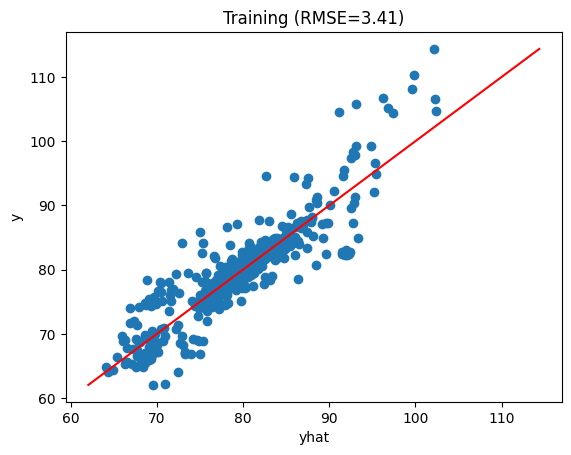

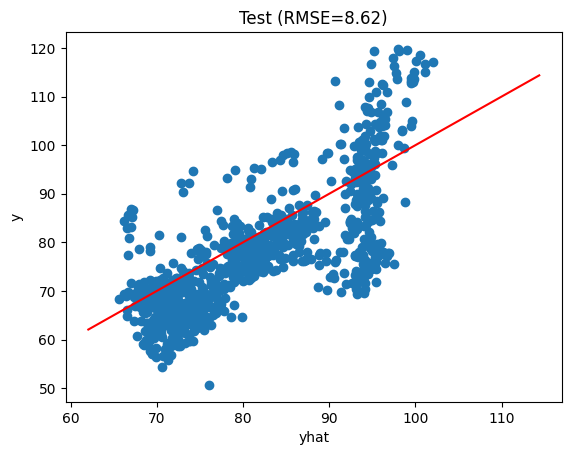

In [ ]:
# 訓練データについて、予測値と実際値とを散布図で比較
plt.scatter(yhattr,ytr)
plt.plot([np.min(ytr),np.max(ytr)],[np.min(ytr),np.max(ytr)],"r-")
plt.xlabel("yhat")
plt.ylabel("y")
plt.title("Training (RMSE={:.2f})".format(rmsetr))

# テストデータについて、予測値と実際値とを散布図で比較
plt.figure()
plt.scatter(yhatte,yte)
plt.plot([np.min(ytr),np.max(ytr)],[np.min(ytr),np.max(ytr)],"r-")
plt.xlabel("yhat")
plt.ylabel("y")
plt.title("Test (RMSE={:.2f})".format(rmsete))


In [ ]:
# 目標変数のばらつき(標準偏差)
print("Training:",np.std(ytr))
print("Test:",np.std(yte))

Training: 7.69423502720212
Test: 12.596425689442382


ここで、別の視点から過剰適合という現象を見てみます。このデータでは、<font color="blue">目標変数(NOX)の値のばらつき（標準偏差）は、訓練データで7.69</font> という値(テストデータで12.6)になっています。

一方、説明変数については、訓練データで、<font color="blue">各説明変数の標準偏差が1</font>になるように標準化を行っていました。
ということは、<font color="red">大雑把に考えて、回帰モデルの係数($a_1,a_2,\cdots,a_9$)の絶対値は、せいぜい1くらいであるべき</font>だと思われます。しかし、実際に得られた係数を見てみると、それよりも遥かに大きなものが存在することが分かります。
棒グラフで各係数の値を表示してみると、

Text(0, 0.5, 'Coefficients')

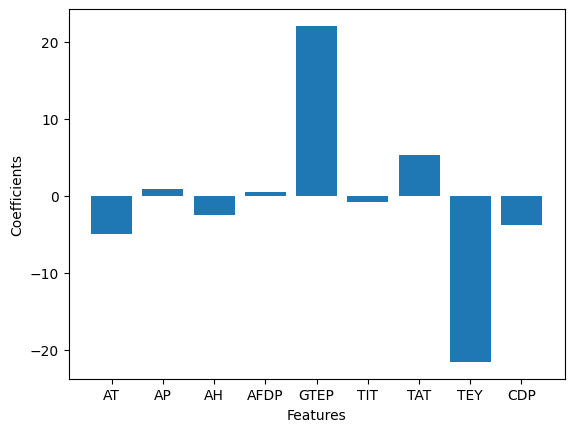

In [ ]:
# パラメータを棒グラフで
plt.bar(dfgt.columns[:9],alp[1:])
plt.xlabel("Features")
plt.ylabel("Coefficients")

この棒グラフで特に目を引くのは、<font color="red">"GTEP"という列名の説明変数($x_5$)の係数$a_5$と、"TEY"という名前の説明変数($x_8$)の係数$a_8$の値が、正負逆でほぼ同じ絶対値(20超)である</font>ということです。
そして、説明変数$x_5$と$x_8$がどのような関係になっているか、散布図を描いてみると、

Text(0.5, 1.0, 'Correlation: 0.985')

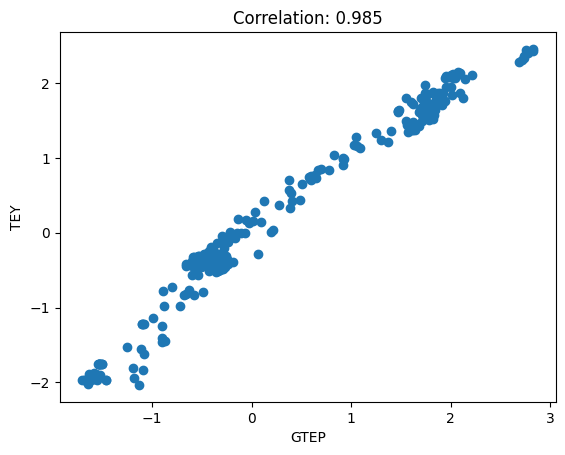

In [ ]:
coef = np.corrcoef(Xtr[:,5],Xtr[:,8])[0,1]
plt.scatter(Xtr[:,5],Xtr[:,8])
plt.xlabel(dfgt.columns[4])
plt.ylabel(dfgt.columns[7])
plt.title("Correlation: {:.3f}".format(coef))


なんと、ほとんど1に近い正の強い相関を持っていることが分かります。つまり、<font color="red">説明変数$x_5$(GTEP)と$x_8$(TEY)は、目標変数$y$(NOX)を予測する上でほとんど同じ情報しか持っていません。</font>それにも関わらず、係数が正負逆で絶対値はほぼ同じということは、回帰モデルの中の、<font color="red">$a_5 \cdot x_5$ と $a_8 \cdot x_8$が互いに打ち消し合うという無駄なことをしている</font>、ということです。

例えて言えば、「アクセルとブレーキを同時に踏む」「暖房と冷房を同時につける」「互いに逆向きに同時に２つのスラスターを吹く」ような<font color="red">エネルギーの無駄使いをしている</font>ようなものです。これが過剰適合のもう一つの正体と言えます。

# 正則化によるモデルの選択

ここまで見てきたように、過剰適合は、<font color="red">限られた量の訓練データに対して複雑過ぎる(パラメータが多すぎる)モデルをフィットさせようとする</font>ことで発生します。
ということは、過剰適合を防ぐには、与えられた訓練データのサイズに対して、<font color="blue">丁度良い複雑さのモデルを選べば良い</font>ということになります。これを、モデル選択(model selection)と呼びます。

モデル選択は統計、機械学習において永遠のテーマとも言え、説明変数の数を減らしてモデルを単純化したり、情報量基準と呼ばれるモデルの複雑さに対してペナルティを課した目的関数を用いたり、パラメータに事前確率分布を課して訓練データの少なさを補ったり、多数のモデルで多数決・重み平均を取る（アンサンブル学習と呼ばれる）ことで般化性能を向上させる、など、様々な
対策が提案されています。
その全てを紹介することはできないのですが、今回は代表的な方法である<font color="blue">**正則化(regularization)**</font> を紹介します。


先週話をしたように、最小二乗法では、残差二乗和
$$
\begin{align}
Q(\boldsymbol{\alpha}) &=  \sum_{i=0}^{n-1} \vert y_i - \boldsymbol{x}_i \boldsymbol{\alpha} \vert^2 \\
&= \Vert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\alpha} \Vert^2
= \left( \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\alpha}\right)^\top
\left( \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\alpha}\right)
\end{align}
$$
を目的関数として、これを最小化するモデルパラメータ$\boldsymbol{\alpha}$を求めました。

一方、先程のNOX排出量予測の例題で見たように、<font color="red">過剰適合が生じるとパラメータ$\boldsymbol{\alpha}$の絶対値が大きくなる</font>現象が見られました。<font color="blue">正則化の考え方は、パラメータ$\boldsymbol{\alpha}$が大きくなることに対して罰則（ペナルティ）を与えることによって、過剰適合を防ぐ</font>というものです。

## L2正則化(Ridge回帰)

最も「基本的な」正則化法が、L2正則化(Tikhonov正則化)で、これを用いた線形回帰はリッジ回帰(Ridge regression)と呼ばれています。その名前の由来のように、<font color="blue">ペナルティ項としてパラメータベクトル$\boldsymbol{\alpha}$のL2ノルム(ユークリッドノルム)の二乗</font>を使います。
従って、リッジ回帰での目的関数は、
$$
J_{\mbox{rid}}(\boldsymbol{\alpha})=Q(\boldsymbol{\alpha})+\lambda \cdot \Vert \boldsymbol{\alpha} \Vert^2
= \left( \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\alpha}\right)^\top
\left( \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\alpha}\right)
+ \lambda \cdot \boldsymbol{\alpha}^\top \boldsymbol{\alpha}
$$
のようになります。ここで、$\lambda$は正則化パラメータと呼ばれるもので、その名の通り、正則化をどの程度効かせるかを調整するパラメータです。

L2正則化がなぜ「最も基本的な」正則化であるかは、目的関数(損失関数) $J_{\mbox{ridge}}(\boldsymbol{\alpha})$の極値条件を計算してみると分かります。すなわち、
$$
\frac{\partial J_{\mbox{rid}}}{\partial \boldsymbol{\alpha}} =
- 2 \boldsymbol{X}^\top\boldsymbol{y}+2 \left( \boldsymbol{X}^\top \boldsymbol{X} + \lambda \cdot \boldsymbol{I} \right) \boldsymbol{\alpha}= \boldsymbol{0} \\
\therefore \left( \boldsymbol{X}^\top \boldsymbol{X} + \lambda \cdot \boldsymbol{I} \right) \boldsymbol{\alpha}=\boldsymbol{X}^\top\boldsymbol{y}
$$
となり、<font color="blue">通常の線形最小二乗法の正規方程式と違うのは、左辺の中の$+ \lambda \cdot \boldsymbol{I}$</font>だけです。そして、この正規方程式の解として、リッジ回帰によるパラメータは、
$$
\hat{\boldsymbol{\alpha}}_\mbox{rid} = \left( \boldsymbol{X}^\top \boldsymbol{X} + \lambda \cdot \boldsymbol{I} \right)^{-1}\boldsymbol{X}^\top\boldsymbol{y}
$$
として求まります。

余談になりますが、リッジ回帰の名前の由来は、$ + \lambda \cdot \boldsymbol{I}$が、対角行列$\boldsymbol{X}^\top \boldsymbol{X}$の対角成分だけを増加させているのが、山の尾根(ridge)を連想させるから、と言われています。


実際に、先程のNOXデータでリッジ回帰を試してみたいと思いますが、ここで一点注意があります。今まで線形回帰モデルをできるだけシンプルに表現するために、説明変数ベクトルの先頭に1を加え、切片(定数項)$\alpha_0$をパラメータベクトルに含めていましたが、<font color="red">通常、この定数項$\alpha_0$は正則化の対象に含めません。</font>

In [ ]:
# 訓練データからリッジ回帰でパラメータを推定
lmd = 50 # 正則化パラメータ
R = lmd * np.eye(10)
R[0,0] = 0.0 # 定数項は正則化の対象外
alp = la.solve(np.dot(Xtr.T,Xtr)+R,np.dot(Xtr.T,ytr))
print("alpha:",alp)
# 訓練データの目標変数の予測値
yhattr = np.dot(Xtr,alp)
# 訓練データのRMSE
rmsetr = np.sqrt(np.mean((ytr - yhattr)**2))
print("Training RMSE:",rmsetr)
# テストデータの目標変数の予測値
yhatte = np.dot(Xte,alp)
# テストデータのRMSE
rmsete = np.sqrt(np.mean((yte - yhatte)**2))
print("Test RMSE:",rmsete)

alpha: [ 7.90657760e+01 -2.52485182e+00  6.10847550e-01 -1.56330136e+00
  5.01105922e-02 -1.19293710e+00 -1.75160812e+00  6.26233174e-01
 -2.13676298e+00 -1.57898200e+00]
Training RMSE: 3.769525917078099
Test RMSE: 7.501076711522163


訓練データに対するRMSEは、通常の最小二乗法のときの3.41から3.77に増加した一方、テストデータに対するRMSEは、8.62から7.50に現象していること、すなわち、<font color="blue">訓練データへの過剰適合が緩和されている</font>ことが分かります。

また、最小二乗法のときには、係数$a_5$と$a_9$とが正負逆で20以上の値になっていましたが、リッジ回帰で得られた各説明変数の係数を棒グラフで表示してみると、

Text(0, 0.5, 'Coefficients')

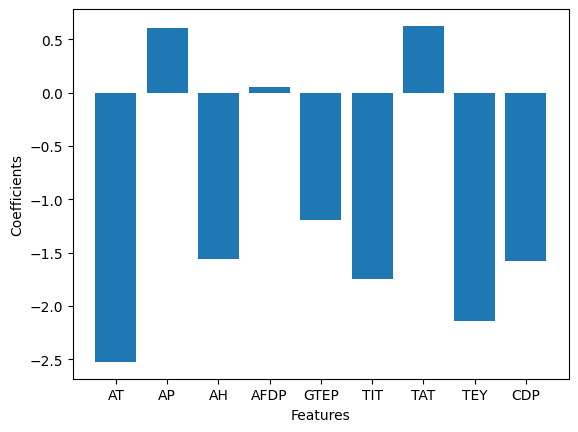

In [ ]:
# パラメータを棒グラフで
plt.bar(dfgt.columns[:9],alp[1:])
plt.xlabel("Features")
plt.ylabel("Coefficients")

このように、絶対値が最も大きいものでも、$a_1=-2.52$となっており、L2正則化項のおかげで、「省エネ」なモデルが得られていることが分かります。

## L1正則化(LASSO回帰)

前述したように、リッジ回帰は通常の最小二乗法との親和性が高く、実装も容易です。しかし、実用面ではL1正則化を用いたLASSO回帰の方が人気です。LASSO回帰の目的関数は、次のようになります。
$$
J_\mbox{LASSO}(\boldsymbol{\alpha})=\Vert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{\alpha} \Vert^2+\lambda \cdot \Vert \boldsymbol{\alpha} \Vert_1
$$
ここで、$\Vert \boldsymbol{\alpha} \Vert_1$はベクトル$\boldsymbol{\alpha}$のL1ノルムで、
$$
\Vert \boldsymbol{\alpha} \Vert_1 = \vert \alpha_1 \vert + \vert \alpha_2 \vert + \ldots + \vert \alpha_K \vert
$$
であり、要するに<font color="red">各回帰パラメータの値の絶対値の和</font>になります。

LASSO回帰は、正則化項としてL2ノルムではなくL1ノルムを使う点がリッジ回帰と異なるのですが、その結果、
* まず、目的関数$J_\mbox{LASSO}$を最小化する$\boldsymbol{\alpha}$の解析解(厳密解)を求めることができません。
* しかも、L1ノルム$\Vert \boldsymbol{\alpha} \Vert_1$は、$\alpha_j=0$において微分不可なので傾きを求めることができないので、数値的に最適化を行う場合も工夫が必要です。
* ただし、目的関数は凸であることので、大局解が保証されます。

という性質を持ちます。LASSOの解法アルゴリズムはいくつか提案されていますが、自分で実装するのはなかなか大変なので、今回は、Pythonの機械学習モジュール scikit-learn に含まれているLASSOモデルを使うことにします。

**(注意)** [scikit-learn では、LASSO](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html)の目的関数を、
$$
J(\boldsymbol{w})=\frac{1}{2N} \Vert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{w}\Vert^2 + \alpha \Vert \boldsymbol{w} \Vert_1
$$
としています。回帰モデルのパラメータが$\boldsymbol{\alpha}$から$\boldsymbol{w}$に、正則化パラメータが$\lambda$の代わりに$\alpha$に変更になっていることに加えて、右辺第一項が残差二乗和$\Vert \boldsymbol{y} - \boldsymbol{X} \boldsymbol{w}\Vert^2$を、<font color="red">$2N$(データサンプル数の2倍)で割っている</font>ところに注意してください。




In [ ]:
from sklearn.linear_model import Lasso
# 正則化パラメータを指定する
model_lasso = Lasso(alpha=0.2)
# 訓練データにフィットさせる。定数項は別途推定される
model_lasso.fit(Xtr[:,1:],ytr)
print(model_lasso.coef_) # 各説明変数の係数
print(model_lasso.intercept_) # 定数項(切片)
# 訓練データのRMSE
rmsetr = np.sqrt(np.mean((ytr - model_lasso.predict(Xtr[:,1:]))**2))
print("RMSE(Training):",rmsetr)
# テストデータのRMSE
rmsete = np.sqrt(np.mean((yte - model_lasso.predict(Xte[:,1:]))**2))
print("RMSE(Test):",rmsete)

[-3.15482113  0.10822659 -1.61211222 -0.         -0.         -0.10842953
  0.         -6.72912037 -0.        ]
79.06577600000001
RMSE(Training): 3.6842298532112716
RMSE(Test): 7.390580323481021


正則化パラメータを適切に指定する必要はありますが、テストデータに対するRMSEが減少し、過剰適合が緩和されていることが分かります。

そして、係数の大きさを棒グラフにしてみると、

<BarContainer object of 9 artists>

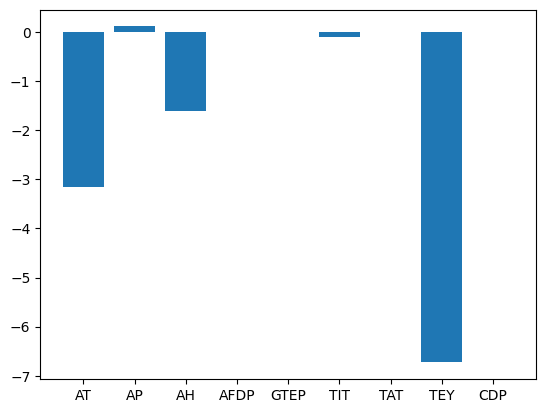

In [ ]:
plt.bar(dfgt.columns[:9],model_lasso.coef_)

ここで注目して欲しいのは、<font color="blue">説明変数$x_4$(AFDP),$x_5$(GTEP),$x_7$(TAT),$x_9$(CDP)の係数$a_4$,$a_5$,$a_7$,$a_9$がいずれも0</font>になっていることです。
<font color="blue">係数が0ということはその説明変数は不要ということを意味しており、冗長な説明変数(特徴量)を取り除いてよりシンプルな(スパースな)モデルを作成する特徴選択の効果がある</font>ということです。

LASSO回帰はリッジ回帰に比べて最適化計算は面倒なのですが、この特徴選択の機能を有していることから、説明変数が非常に多いような回帰問題で良く使われます。
例えば、説明変数が数百とか数千とかあるような回帰問題の場合、どの説明変数を使うかをしらみつぶしに確認していったら組み合わせ爆発してしまいますが、LASSO回帰を使えば（大抵の場合）自動的に冗長で不要な説明変数を取り除いてくれます。

このように書くと、L1正則化(LASSO回帰)の方がL2正則化(リッジ回帰)よりも優れているように思うかもしれませんが、常にそういうわけではありません。
NOX排出量予測の例題では、$x_5$(GTEP)と$x_9$(TEY)の相関が非常に強くて説明変数としては「ほぼ同じ」であると指摘しました。
実際、LASSOで得られた結果を見ると、$a_5=0$, $a_9=-6.73$で、$x_5$を捨てています。一方、リッジ回帰では、$a_5=-1.19$, $a_9=-1.57$となっていて、$x_5$も$x_9$も比較的平等に使っています。言い換えれば、複数の説明変数が同等の情報量を持っていれば、それらをバランス良く組み合わせるような効果があります。

実際、リッジ回帰とLASSO回帰を統合した エラスティックネット(Elastic Net)という回帰モデルがあり、scikit-learnにも用意されています。

### 最適制御との類似性

最適制御では一般に目標状態に実際のシステムの状態をできるだけ近づけることが主な目的となりますが、これは回帰問題では残差二乗和を小さくすることに相当します。一方、いくら最終状態が目標に近づいたとしても、膨大なエネルギーを使ったり非常に出入りの激しい制御を行うのは好ましくありません。そのために、例えば、燃料を大量に使うことや頻繁に制御入力の値を変化させることを妨げるペナルティー項を目的関数に付け加えることがよくあります。これが回帰問題では正則化項に相当します。



## Cross-Validation (交差検定)による正則化パラメータのチューニング

ここまでの話で、リッジ回帰にせよ、LASSO回帰にせよ、正則化の目的と意義を理解してもらえたかと思いますが、残された課題として、<font color="red">「どうやって正則化パラメータ$\lambda$の値を決めたら良いのか？」</font>という問題が残ります。

理想は、<font color="red">テストデータに対するRMSEを最小にするような正則化パラメータの値</font>なのですが、建前上、訓練時にはテストデータにアクセスできないことになっているので、<font color="red">直接テストデータに対するRMSEを最小化するように$\lambda$の値をチューニングするのは禁じ手</font>です。

ではどうしたら良いかというと、(本当は他にもやり方はありますが、)交差検定(cross validation)という方法を用いるのが一般的です。その考え方は、<font color="blue">「訓練時にテストデータを使えないのであれば、与えられた訓練データの一部をテストデータの代わりに、検証データとして使って予測誤差を評価して、正則化パラメータの値をチューニングする」</font>というものです。

特に、訓練データをあらかじめ$K$個のサブセットに分けて、そのうちの1個を検証データとして取っておき、残りの$K-1$個を訓練データとして学習を行ったモデルを検証データで評価する、ということを順番に$K$回行うことを、$K$-分割交差検定($K$-fold cross validation)と呼びます。

以下は、NOXデータの訓練データについて$5$分割交差検定を行い、正則化パラメータの値の候補に対してLASSO回帰モデルの検証誤差を計算したものです。これが最小となるような正則化パラメータの値を採用して、改めて全ての訓練データを使ってモデルを学習すれば良いということになります。


In [ ]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5)
# 正則化パラメータの値の候補
#lst_lmd = [0.01,0.1,1.0,10.0]
lst_lmd = [0.001*2**i for i in range(10)]
lst_sqerr = []
for lmd in lst_lmd:
  # 正則化パラメータの指定
  model_lasso = Lasso(alpha=lmd)
  # 平方誤差の積算
  sqerr = 0.0
  for ixtr,ixval in kf.split(Xtr):
    model_lasso.fit(Xtr[ixtr,1:],ytr[ixtr]) # 訓練データで学習
    # 検証データのSquared Error
    sqerr += np.sum((ytr[ixval] - model_lasso.predict(Xtr[ixval,1:]))**2)
  lst_sqerr.append(sqerr)
  print("lambda={:e}: Sqerr={:f}".format(lmd,sqerr))


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.694e+03, tolerance: 2.585e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.224e+03, tolerance: 2.777e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.837e+03, tolerance: 2.334e

lambda=1.000000e-03: Sqerr=7878.455867
lambda=2.000000e-03: Sqerr=7901.791071
lambda=4.000000e-03: Sqerr=7928.636339
lambda=8.000000e-03: Sqerr=7990.058502
lambda=1.600000e-02: Sqerr=7937.828834
lambda=3.200000e-02: Sqerr=7848.160330
lambda=6.400000e-02: Sqerr=7775.911289
lambda=1.280000e-01: Sqerr=7897.436371
lambda=2.560000e-01: Sqerr=8120.547185
lambda=5.120000e-01: Sqerr=9135.694989


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.138e+01, tolerance: 2.777e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.868e+00, tolerance: 2.462e+00
  model = cd_fast.enet_coordinate_descent(


Text(0, 0.5, 'Validation error')

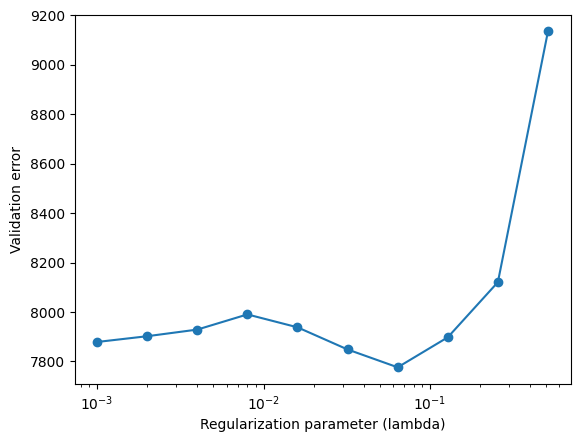

In [ ]:
# 正則化パラメータの値に対する検証エラーの総和をプロット
plt.plot(lst_lmd,lst_sqerr,"o-")
plt.xscale("log")
plt.xlabel("Regularization parameter (lambda)")
plt.ylabel("Validation error")